In [1]:
# Importing the libraries and Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define functions

def load_data(filepath):
    """Load data from a CSV file."""
    return pd.read_csv(filepath, encoding="ISO-8859-1")

def initial_inspection(df):
    """Perform initial data inspection."""
    print(df.head())
    print(df.info())
    print(df.nunique())

def convert_data_types(df):
    """Convert columns to appropriate data types."""
    df["flight_day"] = df["flight_day"].map({
        "Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4,
        "Fri": 5, "Sat": 6, "Sun": 7
    })
    conv_features = ['sales_channel', 'trip_type', 'route',
                     'booking_origin', 'wants_extra_baggage',
                     'wants_preferred_seat', 'wants_in_flight_meals',
                     'booking_complete']
    df[conv_features] = df[conv_features].astype('category')
    return df

def summary_statistics(df):
    """Print summary statistics for numerical columns."""
    print(df.describe())

def plot_distributions(df):
    """Plot distributions of numerical and categorical features."""
    numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
    categorical_cols = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 
                         'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
    
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(3, 3, i)
        sns.countplot(y=df[col])
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df):
    """Plot correlation matrix for numerical features."""
    corr_matrix = df[['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

def handle_missing_values(df):
    """Check and display missing values."""
    missing_values = df.isnull().sum()
    print('Missing Values in Each Column:')
    print(missing_values)

def target_variable_analysis(df):
    """Analyze the distribution of the target variable."""
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df['booking_complete'])
    plt.title('Distribution of Booking Complete')
    plt.show()
    print('\nBooking Complete value counts:')
    print(df['booking_complete'].value_counts(normalize=True))

def plot_feature_relationships(df):
    """Plot relationships between features and the target variable."""
    numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
    categorical_cols = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 
                         'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
    
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x=df['booking_complete'], y=df[col])
        plt.title(f'{col} vs Booking Complete')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 15))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(3, 3, i)
        sns.countplot(x=df[col], hue=df['booking_complete'])
        plt.title(f'{col} vs Booking Complete')
    plt.tight_layout()
    plt.show()

def remove_outliers_iqr(df, numerical_cols, iqr_multiplier=1):
    """Remove outliers using IQR method."""
    Q1 = df[numerical_cols].quantile(0.25)
    Q3 = df[numerical_cols].quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = (df[numerical_cols] < (Q1 - iqr_multiplier * IQR)) | (df[numerical_cols] > (Q3 + iqr_multiplier * IQR))
    return df[~is_outlier.any(axis=1)]

def feature_engineering(df):
    """Perform feature engineering on categorical columns."""
    df = pd.get_dummies(df, columns=['sales_channel'])
    df = pd.get_dummies(df, columns=['trip_type'])
    
    threshold = 100
    counts = df['route'].value_counts()
    to_remove = counts[counts < threshold].index
    df['route'] = df['route'].apply(lambda x: x if x not in to_remove else 'other')
    df = pd.get_dummies(df, columns=['route'])
    
    counts = df['booking_origin'].value_counts()
    to_remove = counts[counts < threshold].index
    df['booking_origin'] = df['booking_origin'].apply(lambda x: x if x not in to_remove else 'other')
    df = pd.get_dummies(df, columns=['booking_origin'])
    
    df.drop(columns=['booking_origin_other', 'route_other'], inplace=True)
    return df

def train_test_split_data(df):
    """Split the data into training and testing sets."""
    X = df.drop(columns=['booking_complete'], axis=1)
    y = df['booking_complete']
    return train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

def train_random_forest(X_train, y_train):
    """Train a Random Forest classifier."""
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    return rfc

def evaluate_model(rfc, X_test, y_test):
    """Evaluate the Random Forest model."""
    y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("R-squared score:", accuracy)
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

def plot_feature_importance(rfc, X):
    """Plot feature importance from the Random Forest model."""
    importances = rfc.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    top_15_importance_df = importance_df.head(15)
    plt.figure(figsize=(10, 6))
    plt.barh(top_15_importance_df['Feature'], top_15_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Top 15 Feature Importance for Random Forest Classifier')
    plt.gca().invert_yaxis()
    plt.show()

   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0        

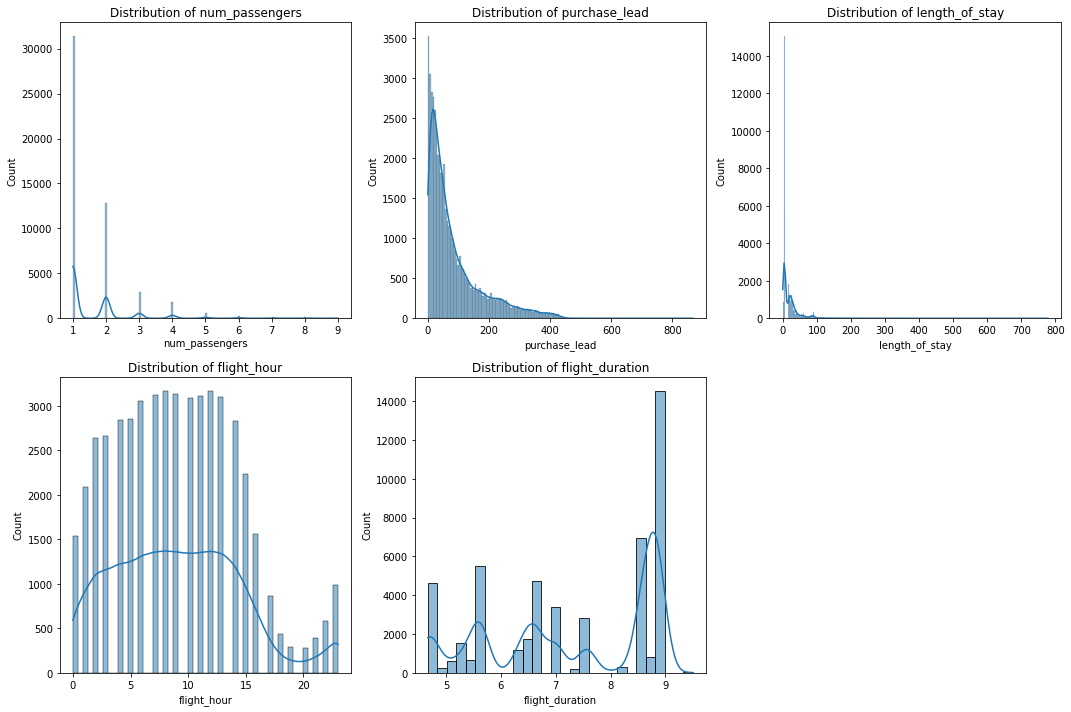

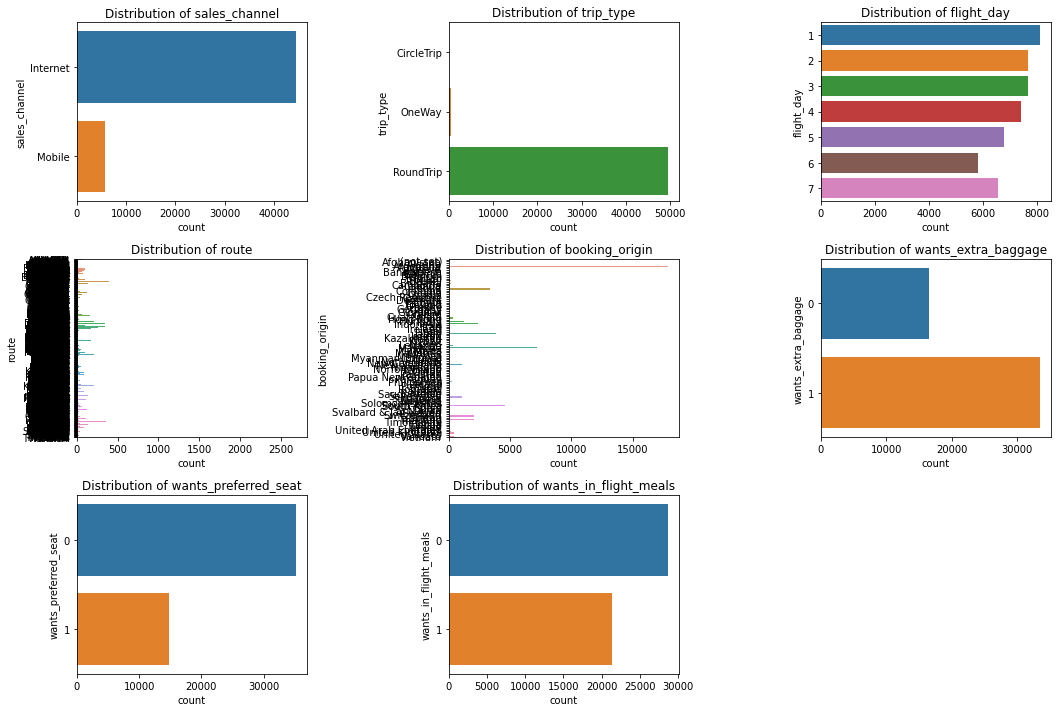

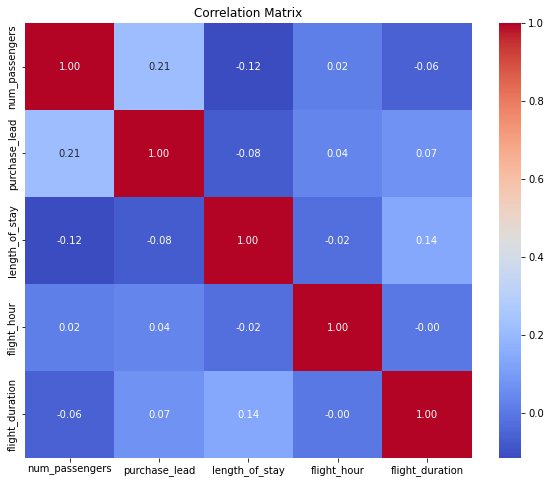

Missing Values in Each Column:
num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


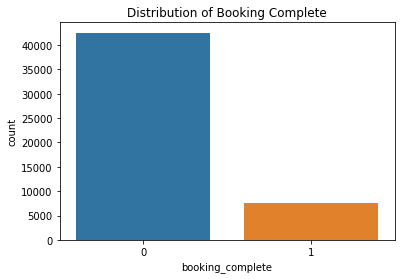


Booking Complete value counts:
0    0.85044
1    0.14956
Name: booking_complete, dtype: float64


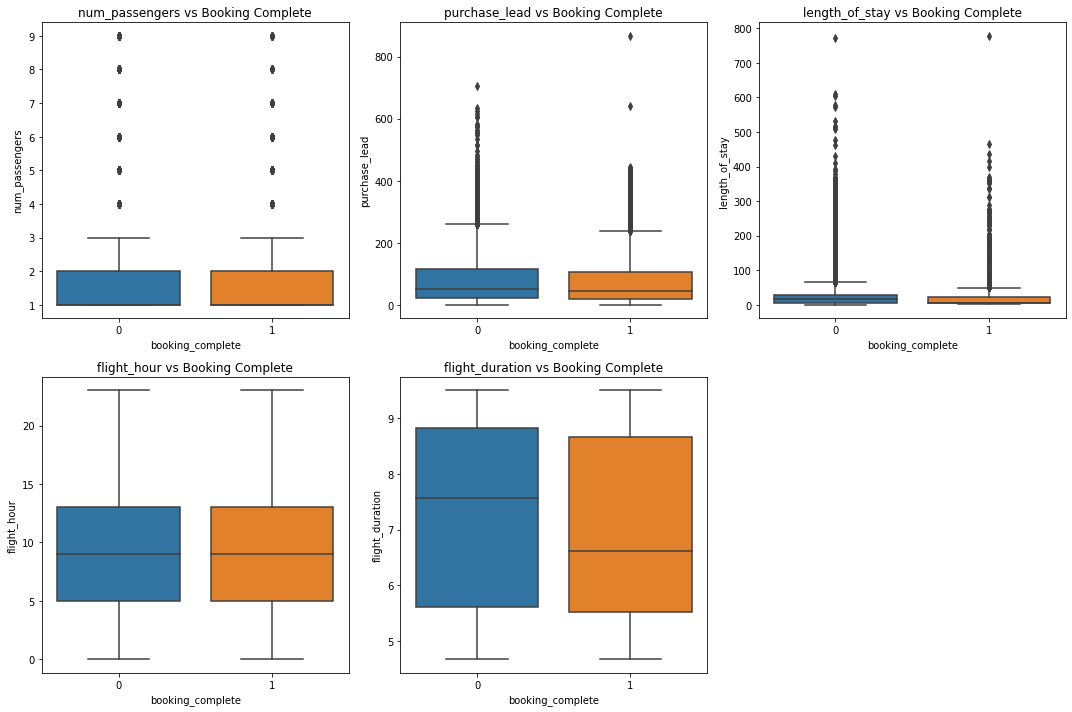

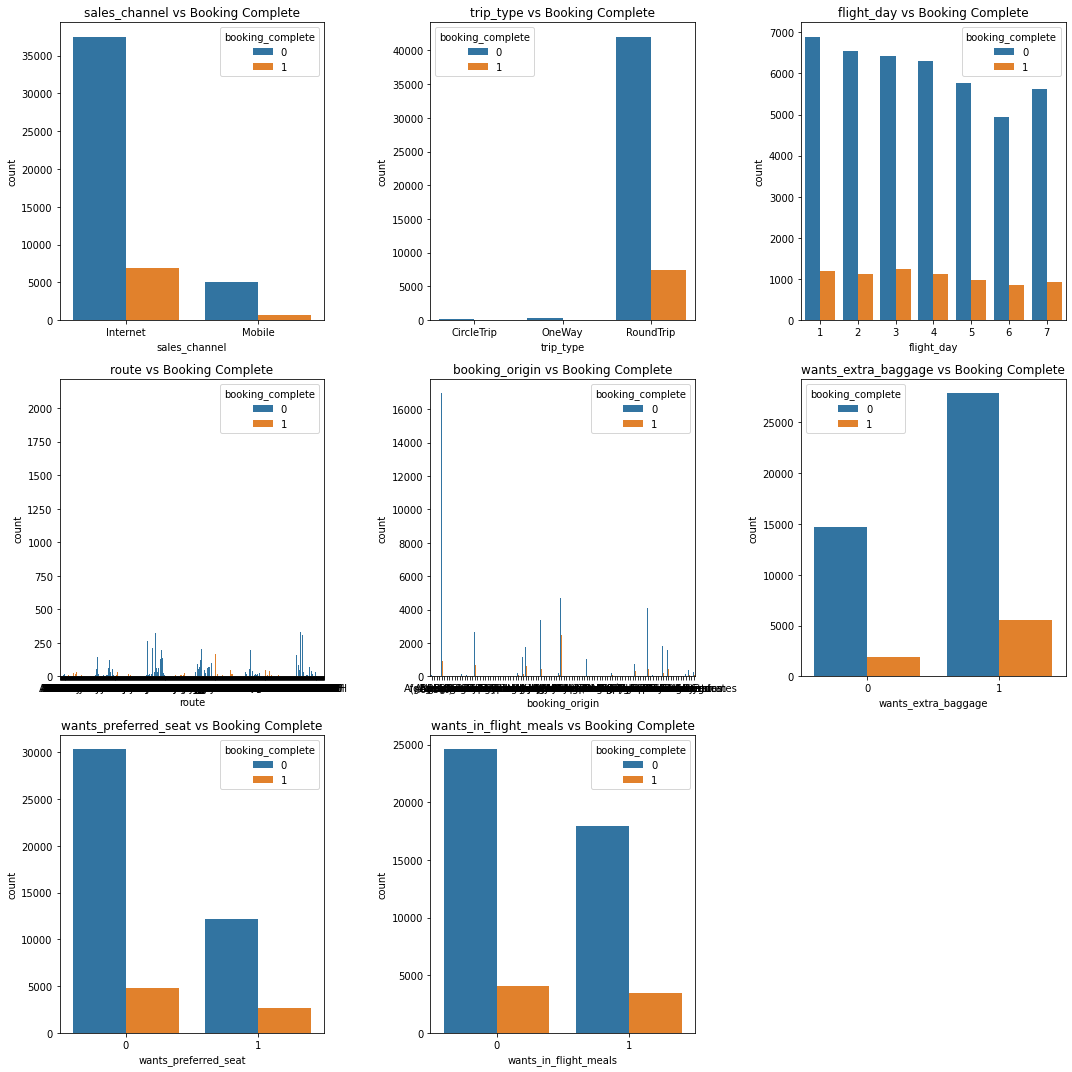

R-squared score: 0.8474810213940649

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.92      6173
           1       0.44      0.12      0.18      1072

    accuracy                           0.85      7245
   macro avg       0.65      0.55      0.55      7245
weighted avg       0.80      0.85      0.81      7245



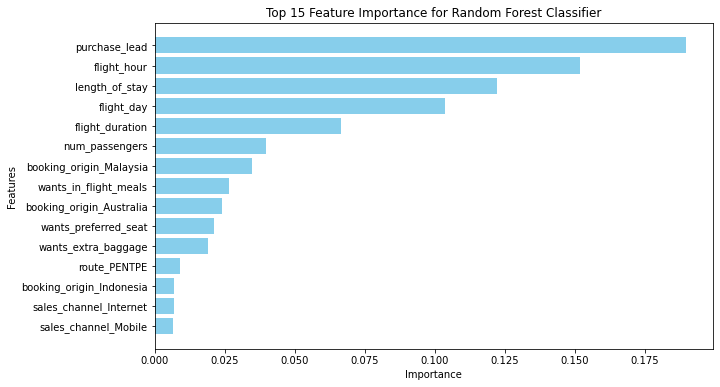

In [2]:
# Main workflow
def main():
    # Load data
    df = load_data("data/customer_booking.csv")
    
    # Initial inspection
    initial_inspection(df)
    
    # Data conversion
    df = convert_data_types(df)
    
    # Summary statistics
    summary_statistics(df)
    
    # Plot distributions
    plot_distributions(df)
    
    # Correlation matrix
    plot_correlation_matrix(df)
    
    # Handle missing values
    handle_missing_values(df)
    
    # Target variable analysis
    target_variable_analysis(df)
    
    # Plot feature relationships
    plot_feature_relationships(df)
    
    # Remove outliers
    df_cleaned = remove_outliers_iqr(df, numerical_cols=['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration'])
    
    # Feature engineering
    df_cleaned = feature_engineering(df_cleaned)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split_data(df_cleaned)
    
    # Train model
    rfc = train_random_forest(X_train, y_train)
    
    # Evaluate model
    evaluate_model(rfc, X_test, y_test)
    
    # Plot feature importance
    plot_feature_importance(rfc, X_train)

# Run the main workflow
if __name__ == "__main__":
    main()